In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt

# Load historical prices

In [ ]:
prices_url = 'https://www.multpl.com/s-p-500-historical-prices/table/by-month'
html_tables = pd.read_html(prices_url)
ruler = '='*80
print(f'There are {len(html_tables)} tables in the webpage.')
for i in range(len(html_tables)):
    print(f'table #{i+1}\n========\n{html_tables[i].head()}\n{ruler}')

There are 1 tables in the webpage.
table #1
           Date  Price Value
0  Jun 20, 2023      4388.71
1   Jun 1, 2023      4221.02
2   May 1, 2023      4146.17
3   Apr 1, 2023      4121.47
4   Mar 1, 2023      3968.56


In [ ]:
r = requests.get(prices_url)
soup = BeautifulSoup(r.content)

tables = soup.findAll('table')
table1 = soup.find_all("table")[0]

all_th = table1.find_all("th")
columns = [x.getText().strip() for x in all_th]


#rename column
columns = [name.replace('\n', '') for name in columns]

print(columns)

all_td = table1.find_all("td")
rows = [x.getText().strip() for x in all_td]

# create matrix for dataframe
row_nums = len(rows) // 2

matrix = np.reshape(rows,(row_nums,2))
df_sp500 = pd.DataFrame(matrix, columns = columns)

df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])
df_sp500['PriceValue'] = df_sp500['PriceValue'].str.replace(',', '').astype(float)

['Date', 'PriceValue']


In [ ]:
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1831 non-null   datetime64[ns]
 1   PriceValue  1831 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


# Load other columns by url

Final predictor variables: <br/> **ShillerPERatio<br/>Earnings<br/>TreasuryRate<br/>Unemployment<br/>CPI<br/>USRealGDP**

In [ ]:
urls = [
        {'name':'ShillerPERatio',
         'url':'https://www.multpl.com/shiller-pe/table/by-month'},
        {'name':'Earnings',
         'url':'https://www.multpl.com/s-p-500-earnings/table/by-month'},
        {'name':'TreasuryRate',
         'url':'https://www.multpl.com/10-year-treasury-rate/table/by-month'},
        {'name':'Unemployment',
         'url':'https://www.multpl.com/unemployment/table/by-month'},
        {'name':'CPI',
         'url':'https://www.multpl.com/cpi/table/by-month'},
        # USRealGDP is only available by quarter, not by month. Expect null values.
        {'name':'USRealGDP',
         'url':'https://www.multpl.com/us-gdp-inflation-adjusted/table/by-quarter'}
        # {'name':'PERatio',
        #  'url':'https://www.multpl.com/s-p-500-pe-ratio/table/by-month'},
        # {'name':'EarningsGrowth',
        # 'url':'https://www.multpl.com/s-p-500-real-earnings-growth/table/by-quarter'},
        # {'name':'DividendYield',
        #  'url':'https://www.multpl.com/s-p-500-dividend-yield/table/by-month'},
        # {'name':'EarningsYield',
        #  'url':'https://www.multpl.com/s-p-500-earnings-yield/table/by-month'},
        # {'name':'Inflation',
        #  'url':'https://www.multpl.com/inflation/table/by-month'},
        # {'name':'USRetailSales',
        #  'url':'https://www.multpl.com/us-retail-sales/table/by-month'},
]

In [ ]:
df_sp_merged = df_sp500

for url in urls:

    r = requests.get(url['url'])
    soup = BeautifulSoup(r.content)
    table_t = soup.find_all("table")[0]

    th_all = table_t.find_all("th")
    columns = [x.getText().strip() for x in th_all]


    #rename column
    columns = [name.replace('\n', '') for name in columns]
    columns[1] = url['name']

    print(f'Processing {columns[1]}')


    td_all = table_t.find_all("td")
    rows = [x.getText().strip() for x in td_all]

    # create matrix for dataframe
    row_nums = len(rows) // 2

    matrix = np.reshape(rows,(row_nums,2))

    df_temp = pd.DataFrame(matrix, columns = columns)

    df_temp[columns[0]]  = pd.to_datetime(df_temp[columns[0]])
    df_temp[columns[1]] = df_temp[columns[1]].str.replace(',', '')
    df_temp[columns[1]] = df_temp[columns[1]].str.replace('\n\nestimate', '')
    df_temp[columns[1]] = df_temp[columns[1]].str.replace(' billion', '')
    df_temp[columns[1]] = df_temp[columns[1]].str.replace(' trillion', '')
    df_temp[columns[1]] = df_temp[columns[1]].str.replace('%', '').astype(float)
    df_sp_merged['key'] = np.where(df_sp_merged['Date'].isnull(), np.nan, df_sp_merged['Date'].dt.to_period('M'))
    df_temp['key'] = np.where(df_temp['Date'].isnull(), np.nan, df_temp['Date'].dt.to_period('M'))

    # merged dataframes using year and month
    if columns[1] == 'USRealGDP' or columns[1] == 'EarningsGrowth':
        df_sp_merged = pd.merge(df_sp_merged, df_temp, how="left", on="key",  suffixes=(None, '_y'))
    else:
        df_sp_merged = pd.merge(df_sp_merged, df_temp, how="inner", on="key",  suffixes=(None, '_y'))

    df_sp_merged = df_sp_merged.drop('Date_y',axis=1)

Processing ShillerPERatio
Processing Earnings
Processing TreasuryRate
Processing Unemployment
Processing CPI
Processing USRealGDP


In [ ]:
df_sp_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 0 to 899
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            900 non-null    datetime64[ns]
 1   PriceValue      900 non-null    float64       
 2   key             900 non-null    period[M]     
 3   ShillerPERatio  900 non-null    float64       
 4   Earnings        900 non-null    float64       
 5   TreasuryRate    900 non-null    float64       
 6   Unemployment    900 non-null    float64       
 7   CPI             900 non-null    float64       
 8   USRealGDP       300 non-null    float64       
dtypes: datetime64[ns](1), float64(7), period[M](1)
memory usage: 70.3 KB


In [ ]:
df_sp_merged.head(5)

,Date,PriceValue,key,ShillerPERatio,Earnings,TreasuryRate,Unemployment,CPI,USRealGDP
0,2022-12-01,3912.38,2022-12,28.32,177.02,3.62,3.5,296.80,20.18
1,2022-11-01,3917.49,2022-11,28.38,181.35,3.89,3.6,297.71,NaN
2,2022-10-01,3726.05,2022-10,27.08,186.04,3.98,3.7,298.01,NaN
3,2022-09-01,3850.52,2022-09,28.23,191.69,3.52,3.5,296.81,20.05
4,2022-08-01,4158.56,2022-08,30.70,193.88,2.90,3.7,296.17,NaN


**Feature Description:**
</br>**PriceValue** - S&P 500 historical prices. Prices are not inflation-adjusted.
</br>**ShillerPERatio** - Shiller PE ratio for the S&P 500. Price earnings ratio is based on average inflation-adjusted earnings from the previous 10 years, known as the Cyclically Adjusted PE Ratio (CAPE Ratio), Shiller PE Ratio, or PE 10.
</br>**Earnings** - S&P 500 Earnings Per Share. 12-month real earnings per share — inflation adjusted
</br>**TreasuryRate** - US 10-year Treasury rate
</br>**Unemployment** - Seasonally adjusted unemployment rate as reported by the US Bureau of Labor Statistics
</br>**CPI** - CPI for all Urban Consumers (CPI-U). Not seasonally adjusted.
</br>**USRealGDP** - US gross domestic product in trillions of chained 2012 dollars (inflation-adjusted).


# Sort by date

In [ ]:
df_sorted = df_sp_merged.sort_values('Date')

In [ ]:
df_sorted.head(10)

,Date,PriceValue,key,ShillerPERatio,Earnings,TreasuryRate,Unemployment,CPI,USRealGDP
899,1948-01-01,14.83,1948-01,10.42,21.09,2.44,3.4,23.7,NaN
898,1948-02-01,14.10,1948-02,10.00,21.70,2.43,3.8,23.5,NaN
897,1948-03-01,14.30,1948-03,10.19,22.22,2.42,4.0,23.4,2.09
896,1948-04-01,15.40,1948-04,10.78,22.49,2.41,3.9,23.8,NaN
895,1948-05-01,16.15,1948-05,11.24,23.03,2.40,3.5,23.9,NaN
894,1948-06-01,16.82,1948-06,11.58,23.47,2.39,3.6,24.1,2.12
893,1948-07-01,16.42,1948-07,11.13,24.06,2.38,3.6,24.4,NaN
892,1948-08-01,15.94,1948-08,10.72,24.83,2.36,3.9,24.5,NaN
891,1948-09-01,15.76,1948-09,10.55,25.70,2.35,3.8,24.5,2.13
890,1948-10-01,16.19,1948-10,10.83,26.71,2.34,3.7,24.4,NaN


In [ ]:
# forward filling for every succeeding 2 months since GDP source data are quarterly
df_sorted['USRealGDP'].ffill(inplace=True)

In [ ]:
# backward filling first 2 rows
df_sorted['USRealGDP'].bfill(inplace=True)

In [ ]:
df_sorted.head(10)

,Date,PriceValue,key,ShillerPERatio,Earnings,TreasuryRate,Unemployment,CPI,USRealGDP
899,1948-01-01,14.83,1948-01,10.42,21.09,2.44,3.4,23.7,2.09
898,1948-02-01,14.10,1948-02,10.00,21.70,2.43,3.8,23.5,2.09
897,1948-03-01,14.30,1948-03,10.19,22.22,2.42,4.0,23.4,2.09
896,1948-04-01,15.40,1948-04,10.78,22.49,2.41,3.9,23.8,2.09
895,1948-05-01,16.15,1948-05,11.24,23.03,2.40,3.5,23.9,2.09
894,1948-06-01,16.82,1948-06,11.58,23.47,2.39,3.6,24.1,2.12
893,1948-07-01,16.42,1948-07,11.13,24.06,2.38,3.6,24.4,2.12
892,1948-08-01,15.94,1948-08,10.72,24.83,2.36,3.9,24.5,2.12
891,1948-09-01,15.76,1948-09,10.55,25.70,2.35,3.8,24.5,2.13
890,1948-10-01,16.19,1948-10,10.83,26.71,2.34,3.7,24.4,2.13


In [ ]:
df_sorted.tail(10)

,Date,PriceValue,key,ShillerPERatio,Earnings,TreasuryRate,Unemployment,CPI,USRealGDP
9,2022-03-01,4391.27,2022-03,34.27,209.35,2.13,3.6,287.50,19.92
8,2022-04-01,4391.30,2022-04,33.89,206.21,2.75,3.6,289.11,19.92
7,2022-05-01,4040.36,2022-05,30.67,202.00,2.90,3.6,292.30,19.92
6,2022-06-01,3898.95,2022-06,29.05,197.33,3.14,3.6,296.31,19.90
5,2022-07-01,3911.73,2022-07,29.00,195.58,2.90,3.5,296.28,19.90
4,2022-08-01,4158.56,2022-08,30.70,193.88,2.90,3.7,296.17,19.90
3,2022-09-01,3850.52,2022-09,28.23,191.69,3.52,3.5,296.81,20.05
2,2022-10-01,3726.05,2022-10,27.08,186.04,3.98,3.7,298.01,20.05
1,2022-11-01,3917.49,2022-11,28.38,181.35,3.89,3.6,297.71,20.05
0,2022-12-01,3912.38,2022-12,28.32,177.02,3.62,3.5,296.80,20.18


In [ ]:
df_sorted.isna().sum()

Date              0
PriceValue        0
key               0
ShillerPERatio    0
Earnings          0
TreasuryRate      0
Unemployment      0
CPI               0
USRealGDP         0
dtype: int64

# Get monthly data

In [ ]:
# -------- Monthly Data
# Price diff
df_sorted['PriceDiff'] = df_sorted['PriceValue'].pct_change()
# ShillerPERatio diff
df_sorted['ShillerPERatioDiff'] = df_sorted['ShillerPERatio'].diff()
# Earnings %change
df_sorted['EarningsDiff'] = df_sorted['Earnings'].pct_change()
# TreasuryRate diff
df_sorted['TreasuryRateDiff'] = df_sorted['TreasuryRate'].diff()
# Unemployment diff
df_sorted['UnemploymentDiff'] = df_sorted['Unemployment'].diff()
# CPI %change
df_sorted['CPIDiff'] = df_sorted['CPI'].pct_change()
# USRealGDP %change
df_sorted['USRealGDPDiff'] = df_sorted['USRealGDP'].pct_change()



In [ ]:
df_sorted.isna().sum()

Date                  0
PriceValue            0
key                   0
ShillerPERatio        0
Earnings              0
TreasuryRate          0
Unemployment          0
CPI                   0
USRealGDP             0
PriceDiff             1
ShillerPERatioDiff    1
EarningsDiff          1
TreasuryRateDiff      1
UnemploymentDiff      1
CPIDiff               1
USRealGDPDiff         1
dtype: int64

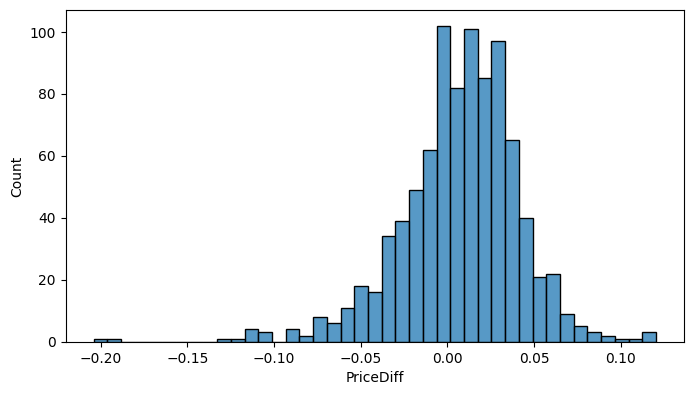

In [ ]:
# price diff histograms
figure, axis = plt.subplots(figsize=(8, 5))
figure.tight_layout(pad=5.0)

sns.histplot(data=df_sorted, x='PriceDiff', ax=axis)

plt.show()

In [ ]:
df_sorted['PriceDiff'].describe()['mean']

0.006836475550745859

In [ ]:
cutoff_bearish =  df_sorted['PriceDiff'].quantile(0.4)
cutoff_bullish =  df_sorted['PriceDiff'].quantile(0.6)


In [ ]:
print(f"cutoff_bearish = {cutoff_bearish}" )
print(f"cutoff_bullish = {cutoff_bullish}" )


cutoff_bearish = 0.0013401405552296635
cutoff_bullish = 0.017216702761972777


## Classify with 3 classes

In [ ]:
# List of conditions
conditions = [
    (df_sorted['PriceDiff'] < cutoff_bearish),
    (df_sorted['PriceDiff'] >= cutoff_bearish) & (df_sorted['PriceDiff'] <= cutoff_bullish),
    (df_sorted['PriceDiff'] > cutoff_bullish)
    ]

# create a list of the values we want to assign for each condition
values = ['Bearish','Neutral','Bullish']

# create a new column and use np.select to assign values to it using our lists as arguments
df_sorted['MTrend'] = np.select(conditions, values)


# Clean and save final csv

In [ ]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 899 to 0
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                900 non-null    datetime64[ns]
 1   PriceValue          900 non-null    float64       
 2   key                 900 non-null    period[M]     
 3   ShillerPERatio      900 non-null    float64       
 4   Earnings            900 non-null    float64       
 5   TreasuryRate        900 non-null    float64       
 6   Unemployment        900 non-null    float64       
 7   CPI                 900 non-null    float64       
 8   USRealGDP           900 non-null    float64       
 9   PriceDiff           899 non-null    float64       
 10  ShillerPERatioDiff  899 non-null    float64       
 11  EarningsDiff        899 non-null    float64       
 12  TreasuryRateDiff    899 non-null    float64       
 13  UnemploymentDiff    899 non-null    float64       

In [ ]:
df_sorted = df_sorted.dropna()


<Axes: xlabel='MTrend', ylabel='count'>

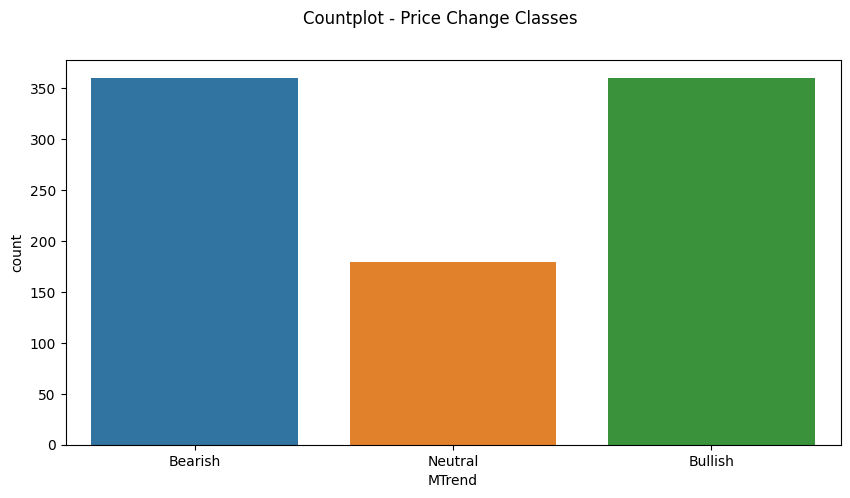

In [ ]:
MTrend = df_sorted['MTrend']

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Countplot - Price Change Classes')

sns.countplot(ax=ax, data=df_sorted, x="MTrend", order=[ 'Bearish', 'Neutral', 'Bullish'])

In [ ]:
df_sorted.to_csv("sp500_final.csv", index=False)

**Target Variables of Interest:**
</br>**MTrend** - Monthly price %change with 5 classes
</br>**MTrend2** - Monthly price %change with 3 classes
</br>**QTrend** - Quarterly price %change with 5 classes
</br>**QTrend2** - Quarterly price %change with 3 classes

In [ ]:
df_sorted[["Date", "PriceValue", "PriceDiff"]].sort_values('Date',ascending=False)

,Date,PriceValue,PriceDiff
0,2022-12-01,3912.38,-0.001304
1,2022-11-01,3917.49,0.051379
2,2022-10-01,3726.05,-0.032326
3,2022-09-01,3850.52,-0.074074
4,2022-08-01,4158.56,0.063100
...,...,...,...
894,1948-06-01,16.82,0.041486
895,1948-05-01,16.15,0.048701
896,1948-04-01,15.40,0.076923
897,1948-03-01,14.30,0.014184


In [ ]:
df_sorted[['Date', 'ShillerPERatio', 'ShillerPERatioDiff']].sort_values('Date')

,Date,ShillerPERatio,ShillerPERatioDiff
898,1948-02-01,10.00,-0.42
897,1948-03-01,10.19,0.19
896,1948-04-01,10.78,0.59
895,1948-05-01,11.24,0.46
894,1948-06-01,11.58,0.34
...,...,...,...
4,2022-08-01,30.70,1.70
3,2022-09-01,28.23,-2.47
2,2022-10-01,27.08,-1.15
1,2022-11-01,28.38,1.30


# Previous Thresholds

In [ ]:
df_sorted['PriceDiff'].describe()['50%']

0.010147199721278533

In [ ]:

###
#cutoff_vbearish_temp = df_sorted['PriceDiff'].describe()['25%']
cutoff_bearish_temp = min(df_sorted['PriceDiff'].describe()['mean'],df_sorted['PriceDiff'].describe()['50%'])
cutoff_bullish_temp =  max(df_sorted['PriceDiff'].describe()['mean'],df_sorted['PriceDiff'].describe()['50%'])
#cutoff_vbullish_temp =  df_sorted['PriceDiff'].describe()['75%']

#cutoff_vbearish_qtr_temp1 = df_sorted['PriceDiffQtr'].describe()['25%']
#cutoff_bearish_qtr_temp1 = min(df_sorted['PriceDiffQtr'].describe()['mean'],df_sorted['PriceDiffQtr'].describe()['50%'])
#cutoff_bullish_qtr_temp1 =  max(df_sorted['PriceDiffQtr'].describe()['mean'],df_sorted['PriceDiffQtr'].describe()['50%'])
#cutoff_vbullish_qtr_temp1=  df_sorted['PriceDiffQtr'].describe()['75%']


## Classify with 3 classes

In [ ]:

# List of conditions
conditions_temp = [
    (df_sorted['PriceDiff'] < cutoff_bearish_temp),
    (df_sorted['PriceDiff'] >= cutoff_bearish_temp) & (df_sorted['PriceDiff'] <= cutoff_bullish_temp),
    (df_sorted['PriceDiff'] > cutoff_bullish_temp)
    ]

# create a list of the values we want to assign for each condition
values_temp = ['Bearish','Neutral','Bullish']

# create a new column and use np.select to assign values to it using our lists as arguments
df_sorted['MTrend_temp'] = np.select(conditions_temp, values_temp)


# List of conditions
#conditions2 = [
#    (df_sorted['PriceDiffQtr'] < cutoff_bearish_qtr_temp1),
#    (df_sorted['PriceDiffQtr'] >= cutoff_bearish_qtr_temp1) & (df_sorted['PriceDiffQtr'] <= cutoff_bullish_qtr_temp1),
#    (df_sorted['PriceDiffQtr'] > cutoff_bullish_qtr_temp1)
#    ]

# create a new column and use np.select to assign values to it using our lists as arguments
#df_sorted['QTrend2'] = np.select(conditions2, values2)


<Axes: xlabel='MTrend', ylabel='count'>

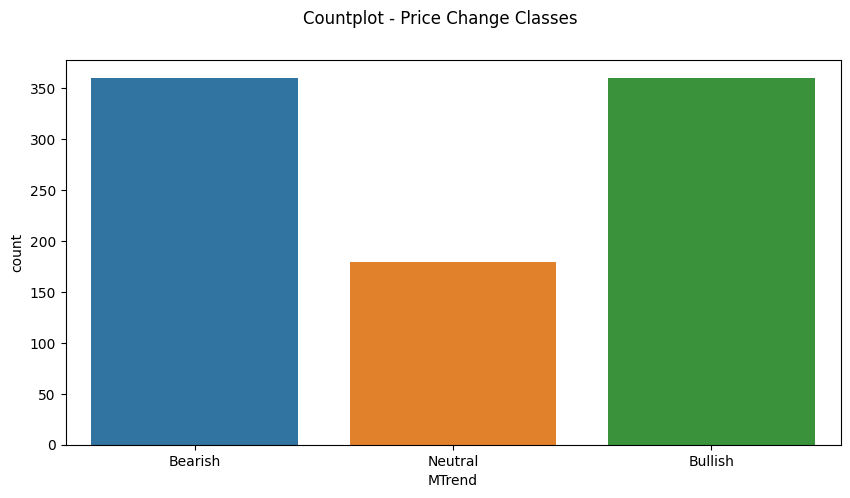

In [ ]:
MTrend_temp = df_sorted['MTrend_temp']

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Countplot - Price Change Classes')

sns.countplot(ax=ax, data=df_sorted, x="MTrend", order=['Bearish', 'Neutral', 'Bullish'])